In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tqdm.notebook import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the data
df = pd.read_csv('car train_data.csv')

In [3]:
# Check the head
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6018 entries, 0 to 6017
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6018 non-null   object 
 1   Location           6018 non-null   object 
 2   Year               6018 non-null   int64  
 3   Kilometers_Driven  6018 non-null   int64  
 4   Fuel_Type          6018 non-null   object 
 5   Transmission       6018 non-null   object 
 6   Owner_Type         6018 non-null   object 
 7   Mileage            6016 non-null   object 
 8   Engine             5982 non-null   object 
 9   Power              5982 non-null   object 
 10  Seats              5976 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6018 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.3+ KB


##### Let us quickly fix few direct visible dataset problems

In [5]:
# Split brand and Model
df[["Brand","Model"]] = df.Name.str.split(" ",1,expand=True)
df.drop('Name',inplace=True, axis=1)

In [6]:
# Mileage col
dff2=df[df['Mileage'].str.contains("kmpl")==True]
dff2.Mileage=dff2.Mileage.str.replace("kmpl","")
dff2.Mileage=dff2.Mileage.astype(float)


dff=df[df['Mileage'].str.contains("km/kg")==True]
dff.Mileage=dff.Mileage.str.replace("km/kg","")
dff.Mileage=dff.Mileage.astype(float)
dff.Mileage*= 0.8

frames=[dff,dff2]
df=pd.concat(frames)
df.sort_index(ascending=True,inplace=True)

In [7]:
# Engine col
df.Engine = df.Engine.str.replace('CC','')
df.Engine=df.Engine.replace(np.nan,0)
df.Engine=df.Engine.astype(float)
df.Engine.isnull().sum()

0

In [8]:
# Power col
df.Power=df.Power.str.replace("bhp","")
df.Power=df.Power.str.replace("null","0")
df.Power=df.Power.replace(np.nan,0)
df.Power=df.Power.astype(float)

In [9]:
# Seat col
df.Seats=df.Seats.replace(np.nan,0)
# Upper case and lower case are present so convert all to upper
df.Brand=df.Brand.replace('Isuzu','ISUZU')

In [10]:
# To replace the 0, we will apply a trick and instead of taking a whole mean we will take mean or mode brand wise ;)
unique_brands=df.Brand.unique().tolist()
di = dict()
for name in unique_brands:
    filter_df = df[df['Brand']==name]
    mileage_mean = filter_df[filter_df.Mileage!=0].Mileage.mean()
    engine_mean = filter_df[filter_df.Engine!=0].Engine.mean()
    power_mean = filter_df[filter_df.Power!=0].Power.mean()
    seat_mode = filter_df.Seats.mode()[0]
    kmdriven_mean = filter_df[filter_df.Kilometers_Driven!=0].Kilometers_Driven.mean()
    transmission_mode = filter_df.Transmission.mode()[0]
    di[name]={'Mileage':mileage_mean,
         'Power':power_mean,
         'Engine':engine_mean,
         'Seats':seat_mode,
         'Kilometers_Driven':kmdriven_mean,
         'Transmission':transmission_mode}
with open("../models/null_info_brand_wise.pickle","wb") as f:
    pickle.dump(di, f)

In [12]:
# Since our dict is ready let us replace the values.
rep_cols = ['Mileage','Engine','Power','Seats','Kilometers_Driven','Transmission']
for col_name in tqdm(rep_cols):
    for brand, brand_val in zip(df["Brand"],df[col_name]):
        df.loc[df.Brand == brand, col_name] = df.loc[df.Brand == brand, col_name].replace(0,di[brand][col_name])

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6016 entries, 0 to 6017
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6016 non-null   object 
 1   Year               6016 non-null   int64  
 2   Kilometers_Driven  6016 non-null   int64  
 3   Fuel_Type          6016 non-null   object 
 4   Transmission       6016 non-null   object 
 5   Owner_Type         6016 non-null   object 
 6   Mileage            6016 non-null   float64
 7   Engine             6016 non-null   float64
 8   Power              6016 non-null   float64
 9   Seats              6016 non-null   float64
 10  New_Price          823 non-null    object 
 11  Price              6016 non-null   float64
 12  Brand              6016 non-null   object 
 13  Model              6016 non-null   object 
dtypes: float64(5), int64(2), object(7)
memory usage: 705.0+ KB


In [14]:
# Drop the New Price Column as majority is Null.
df.drop('New_Price', axis=1, inplace=True)

##### Let us perform some EDA 

In [15]:
# User Defined Functions
# Custom defined functions
#annotate_bar function taken from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
#and modified as per requirement in our case
sns.set(style='whitegrid')
def annotate_bar(ax,percent=False,fontsize=12): 
    """Add labels to the end of each bar in a bar chart.
       Function taken from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
       ----------Edited as per requirement----------
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 2
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if percent:
            label = "{:.1f}%".format(y_value)
        else:
            label = "{:.1f}".format(y_value)
            

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            fontsize=fontsize,          # Set font size
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
    
def plot_cnt(x,data,palette='husl', hue=None, show_top=None, rot= 0,ha = 'center', fig_size = (20,5)):
    plt.figure(figsize=fig_size)
    ax = sns.countplot(x = x,data = data,palette=palette,hue = hue, order=data[x].value_counts().iloc[:show_top].index)
    plt.xticks(rotation=rot, horizontalalignment=ha)
    annotate_bar(ax)
    
def plot_bar(x,y,data,palette="rocket",hue= None, rot= 0,ha = 'center', fig_size = (20,5)):
    plt.figure(figsize=fig_size)
    ax = sns.barplot(x=x, y=y, data=data, palette=palette,ci=None, hue=hue)
    plt.xticks(rotation=rot, horizontalalignment=ha)
    annotate_bar(ax)

def set_title(titl,color = 'DarkMagenta'):
    plt.title(titl,{'color' :color,'fontsize':14})

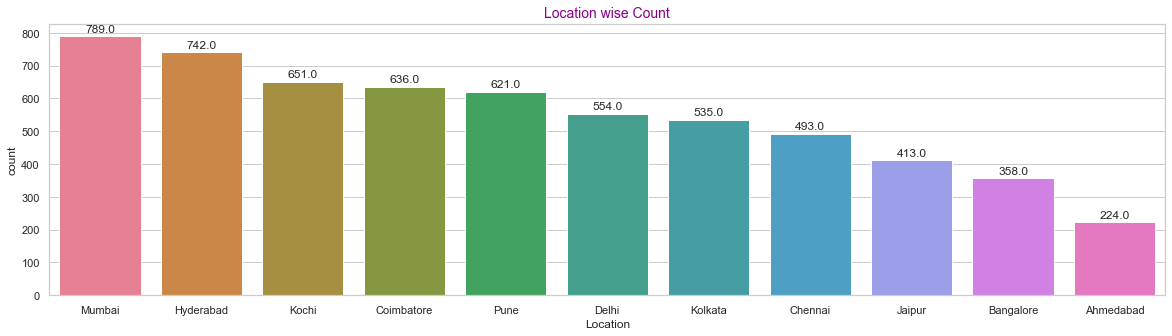

In [16]:
# Count plot for Location
plot_cnt('Location',df)
set_title('Location wise Count')

- Most number of vehicles are sold in Mumbai followed by Hydrabad
- Ahmedabad is last in the list

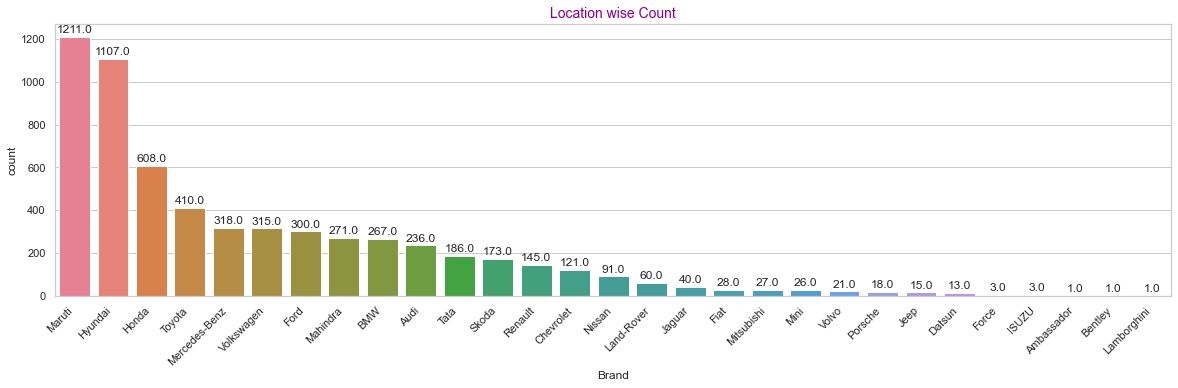

In [17]:
# Count plot for Brand
plot_cnt('Brand',df,rot= 45, ha = 'right')
set_title('Location wise Count')

- As expected Maruti Solf most Number of Vehicles followed by Hyundai.
- Brands like Volvo, Porsche, Bentley have sold very less units.

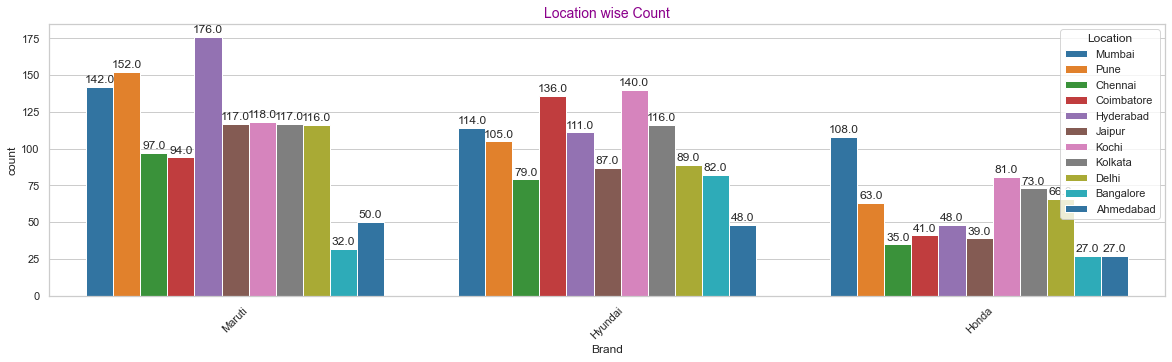

In [18]:
# Brand and Location comparsion
plot_cnt('Brand',df,hue='Location', palette='tab10', rot= 45, show_top=3)
set_title('Location wise Count')

- Maruti has sold maximum number of Vehicles in Hydrabad.
- Hyundai has sold Maximul number of Vehicles in Kochi.
- Honda has sold maximum in Mumbai.

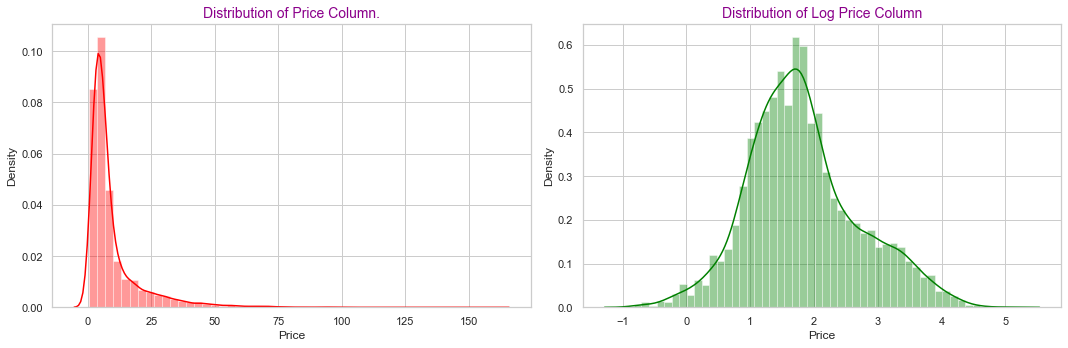

In [19]:
# Distribution of price
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['Price'],bins=50,color='red')
set_title('Distribution of Price Column.')
plt.subplot(1,2,2)
sns.distplot(np.log(df['Price']),bins=50,color='green')
set_title('Distribution of Log Price Column')

plt.tight_layout()
plt.show()

- Price is left skewed as majority of of the vehicles sold was between 1 to 20 Lakhs.
- Log transformation seems to work well in this situation.

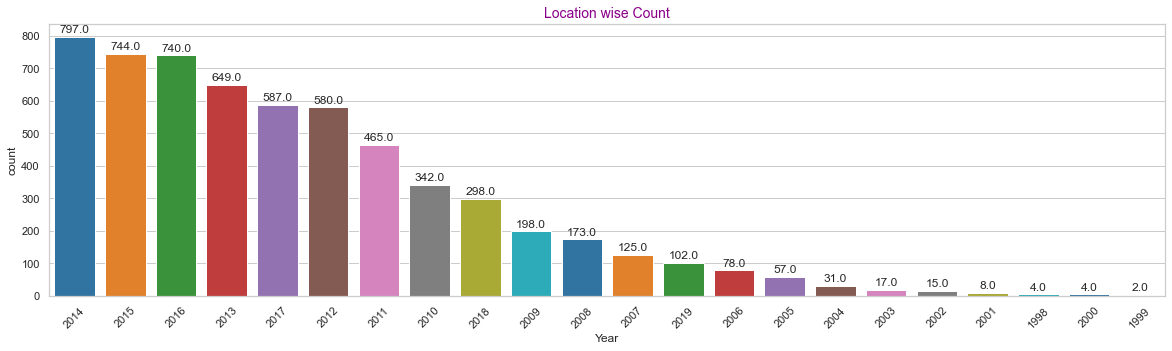

In [20]:
# Year wise performance
plot_cnt('Year',df, palette='tab10', rot= 45)
set_title('Location wise Count')

- Most number of cars are sold in 2014

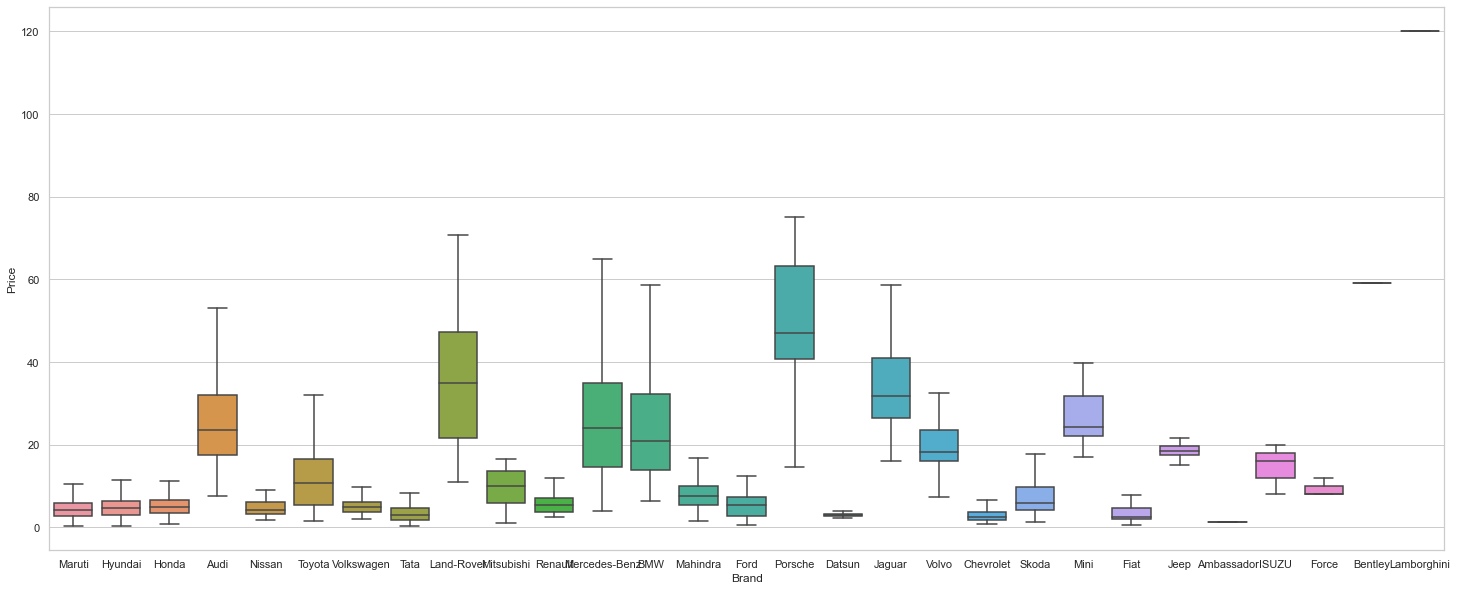

In [21]:
# Plot the boxplot for Price and Brand
plt.figure(figsize=(25,10))
sns.boxplot(data=df, y="Price", x="Brand",showfliers=False)
plt.show()

- That is interesting, Lamborghini has sold for more than 100 Lakh even is Second hand.
- Top 3 sellers i.e Maruti, Hyundia, Honda has very similar price distribution.
- Land-Rover and Porsche have similar distributio.
- BMW and Mercedes are very similar in price.
- These are soo relatable. 😍

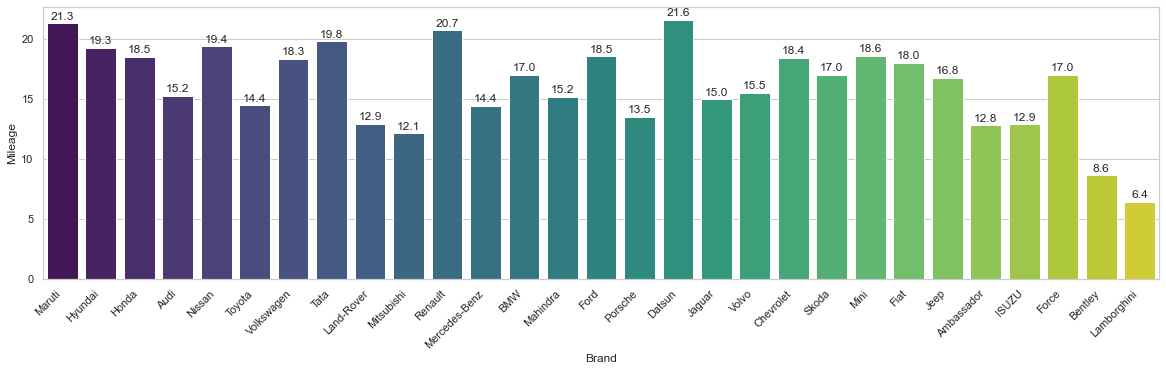

In [22]:
# Check the avg. Mileage of each brand
plot_bar('Brand','Mileage',df,palette="viridis",rot= 45, ha = 'right')

- Datsun has best Mileage. May be only thing good about this brand. 😆
- Maruti, Hyundai, Honda has mileage of 21.3, 19.3, 18.5 respectively.

##### Let us work on the Encoding part now and store it in dict to be used later.

In [23]:
def create_label_pickle(attrib, output_file):
    enc.fit(df[attrib]) 
    le_mapping = dict(zip(enc.transform(enc.classes_), enc.classes_))
    with open(f"../models/{output_file}.pickle","wb") as f:
        pickle.dump(le_mapping, f)
    print(f"Pickle file is created: {output_file}.pickle")

In [24]:
# Encode Object
enc = LabelEncoder()

In [25]:
# Let us now work on the Encoding part
# Transmission col
df.Transmission = enc.fit_transform(df.Transmission)

In [26]:
# Create reverse map for Models
enc.fit(df['Model']) 
le_mapping = dict(zip(enc.classes_, enc.transform(enc.classes_)))
output_file = "Model_rev_dict"
with open(f"../models/{output_file}.pickle","wb") as f:
    pickle.dump(le_mapping, f)
print(f"Pickle file is created: {output_file}.pickle")

Pickle file is created: Model_rev_dict.pickle


In [27]:
enc_arr = ['Location','Model','Fuel_Type','Owner_Type'] # We keep Brand now.To be used later.
for val in tqdm(enc_arr):
    create_label_pickle(val,f'{val}_dict')
    df[val] = enc.fit_transform(df[val])

  0%|          | 0/4 [00:00<?, ?it/s]

Pickle file is created: Location_dict.pickle
Pickle file is created: Model_dict.pickle
Pickle file is created: Fuel_Type_dict.pickle
Pickle file is created: Owner_Type_dict.pickle


In [28]:
# Creting map for Brand
create_label_pickle('Brand',f'Brand_dict')

Pickle file is created: Brand_dict.pickle


In [29]:
#Save the processed DataFrame
with open(f"../models/df_usex.pickle","wb") as f:
    df = pickle.dump(df, f)
print(f"Pickle file for processed DataFrame is saved.")

Pickle file for processed DataFrame is saved.


In [30]:
# Let us read the saved df and move ahead to verify. We could have also used previous df, both are same thing.
with open(f"../models/df_usex.pickle","rb") as f:
    df = pickle.load(f)
print(f"Pickle file for processed DataFrame is fetched.")
display(df.head(2))

Pickle file for processed DataFrame is fetched.


,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
0,9,2010,72000,0,1,0,21.28,998.0,58.16,5.0,1.75,Maruti,1640
1,10,2015,41000,1,1,0,19.67,1582.0,126.20,5.0,12.50,Hyundai,460


##### Let us create 2 models, one with Model and Another without model.

In [33]:
# Encode Brand
df.Brand = enc.fit_transform(df.Brand)

In [34]:
X1 = df.drop('Price', axis=1)
X2 = df.drop(['Price','Model'], axis=1)
Y = df['Price']

In [35]:
def eval_model(act, pred):
    mse = mean_squared_error(act,pred)
    r2 = r2_score(act,pred)
    print("MSE is: %.3f , R2 Score is: %.3f"%(mse,r2))
def train_test_eval(inp_model, x_train, x_test, y_train, y_test):
    print(f"Input_model is {inp_model}")
    print("Train data Evaluation:")
    y_train_pred = inp_model.predict(x_train)
    eval_model(y_train, y_train_pred)
    print("Test data Evaluation:")
    y_test_pred = inp_model.predict(x_test)
    eval_model(y_test, y_test_pred)

#### Random Forest

##### Model 1: With Model attribute 

In [36]:
# Train test split
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y, test_size = 0.1)

In [37]:
rf_model1 = RandomForestRegressor()
rf_model1.fit(X1_train,Y_train)

RandomForestRegressor()

In [38]:
# Model Evaluation
train_test_eval(rf_model1, X1_train, X1_test, Y_train, Y_test)

Input_model is RandomForestRegressor()
Train data Evaluation:
MSE is: 1.956 , R2 Score is: 0.985
Test data Evaluation:
MSE is: 8.739 , R2 Score is: 0.921


##### Model 2: Without Model Attribute

In [39]:
# Train test split
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y, test_size = 0.1)

In [40]:
rf_model2 = RandomForestRegressor()
rf_model2.fit(X2_train,Y_train)

RandomForestRegressor()

In [41]:
# Model Evaluation
train_test_eval(rf_model2, X2_train, X2_test, Y_train, Y_test)

Input_model is RandomForestRegressor()
Train data Evaluation:
MSE is: 1.736 , R2 Score is: 0.986
Test data Evaluation:
MSE is: 21.056 , R2 Score is: 0.823


#### XGBoost

##### Model 1: With Model attribute 

In [42]:
# Train test split
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y, test_size = 0.1)

In [43]:
xg_model1 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=20, max_depth=5)
xg_model1.fit(X1_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
# Model Evaluation
train_test_eval(xg_model1, X1_train, X1_test, Y_train, Y_test)

Input_model is XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Train data Evaluation:
MSE is: 4.582 , R2 Score is: 0.964
Test data Evaluation:
MSE is: 6.914 , R2 Score is: 0.942


##### Model 2: Without Model attribute 

In [45]:
# Train test split
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y, test_size = 0.1)

In [46]:
xg_model2 = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=50, max_depth=3)
xg_model2.fit(X2_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
# Model Evaluation
train_test_eval(xg_model2, X2_train, X2_test, Y_train, Y_test)

Input_model is XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Train data Evaluation:
MSE is: 6.449 , R2 Score is: 0.947
Test data Evaluation:
MSE is: 25.431 , R2 Score is: 0.847


#### XGBoost with few modified parameters is performing well, let us save it now.
- Feel free to do a rigorous tuning.

In [48]:
joblib.dump(xg_model1,'../models/xgboost_with_model_attribute.ml')
joblib.dump(xg_model2,'../models/xgboost_without_model_attribute.ml')

['../models/xgboost_without_model_attribute.ml']

#### How to predict using XGBoost

In [49]:
with open('../models/xgboost_with_model_attribute.ml','rb') as f:
    x1 = joblib.load(f)

In [50]:
col_names = x1.get_booster().feature_names

In [51]:
print(col_names)

['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'Brand', 'Model']


In [52]:
vector = [7.0000e+00, 2.0180e+03, 5.2827e+04, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 1.2700e+01, 2.1790e+03, 1.8770e+02, 5.0000e+00,
       1.5000e+01, 1.2210e+03]

In [53]:
dx = pd.DataFrame([vector], columns=col_names)

In [54]:
x1.predict(dx)[0]

46.527554